In [1]:
import pandas as pd
import streamlit as st
import plotly.express as px
import plotly.subplots as sp
import numpy as np
import functions as mlfn
import scipy.stats as stats

# File and folder path
fol = ''
fn = 'FS_Golf_DB.xlsx'
df = pd.read_excel(fol+fn)


In [2]:

import matplotlib.pyplot as plt
import statsmodels.graphics.api as smg
%matplotlib inline


In [3]:
dimensions = ['Club','Golfer','Session','Shot_Type','Mode']

#  No data in 'Curve_Dist_yds
# Lateral_Impact_in and Vertical_Impact_in are not in the data until 'Mombo ShotID' 407
num_columns = ['Ball_mph', 'Club_mph', 'Smash_Factor', 'Carry_yds','Total_yds', 'Roll_yds', 'Swing_H', 'Height_ft', 'Time_s', 'AOA',
       'Spin_Loft', 'Swing_V', 'Spin_Axis', 'Lateral_yds', 'FTP', 'FTT','Dynamic_Loft', 'Club_Path', 'Launch_H', 'Launch_V', 'DescentV', 
       'Lateral_Impact_in', 'Vertical_Impact_in']

clubs = ['Driver','3 Wood','5 Wood','4 Iron','5 Iron','6 Iron','7 Iron', '8 Iron','9 Iron', 'Pitching Wedge',  'Gap Wedge','Sand Wedge' , 'Lob Wedge']



In [4]:
#### Helper functions   ################################################################
# Convert value with error handling
def convert_value(value):
    """
    Converts any value like '40R' or '20L' to numerical form:
    - '40R' becomes -40
    - '20L' becomes 20
    Returns None for invalid entries.
    """
    try:
        value = str(value).strip()  # Ensure value is a string and remove spaces
        number, direction = value[:-1], value[-1].upper()  # Split number and direction
        number = float(number)
        return -number if direction == 'R' else number if direction == 'L' else None
    except (ValueError, AttributeError):
        return None  # Return None for invalid entries

# Convert entire column and handle missing column errors
def convert_column(df, col):
    """
    Converts all values in a column using convert_value.
    Handles missing column errors gracefully.
    """
    if col in df.columns:
        df[col] = df[col].apply(convert_value)
        print(f"Column '{col}' successfully converted.")
    else:
        st.error(f"The column '{col}' is missing from the data.")
########################################################################################

def process_df(df):
    clubs = ['Driver','3 Wood','5 Wood','4 Iron','5 Iron','6 Iron','7 Iron', '8 Iron','9 Iron', 'Pitching Wedge',  'Gap Wedge','Sand Wedge' , 'Lob Wedge']
    # Cleaning the column names
    # Clean column names to ensure consistency
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True).str.replace('\xa0', ' ').str.strip().str.replace(' ', '_')

    # Convert Time to strings for Session variable
    df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d  %I:%M:%S %p', errors='coerce')
    df['Session'] = df['Time'].dt.strftime('%Y %b %d %I:%M %p')  # Or any simpler string representation

    # Convert all the columns that have L & R in the data        
    lrcols = ['Swing_H','Spin_Axis','Lateral_yds','FTP','FTT','Club_Path','Launch_H']
    for col in lrcols:
        convert_column(df,col)

    # Coerce any string values to numeric in num_columns
    df[num_columns] = df[num_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate averages per golfer, session and per Club etc.  Aggregation
    # s ############################
    # 1. Parse & sort
    df['Session_dt'] = pd.to_datetime(df['Session'], format='%Y %b %d %I:%M %p')
    df = df.sort_values('Session_dt').copy()
    # 2. Convert Session to ordered categorical
    sorted_sessions = df['Session'].unique()
    df['Session'] = pd.Categorical(
        df['Session'],
        categories=sorted_sessions,
        ordered=True             )
    # 3. Pivot with Sessions
    df_pivot = df.pivot_table(
        index='Club',
        columns=['Golfer', 'Session'],
        values=num_columns, 
        aggfunc='mean')
    # 4. (Optional) Reindex columns to ensure Session is in ascending chronological order
    df_sessions = df_pivot.reindex(columns=sorted_sessions, level='Session')

    df_golfer = df.pivot_table(
        index='Club',
        columns=['Golfer'],
        values=num_columns, 
        aggfunc='mean')
    df_golfer = df_golfer.reindex(clubs)
    df_sessions = df_sessions.reindex(clubs)
    
    return df,df_sessions,df_golfer

In [5]:
df, df_sessions, df_golfer = process_df(df)       # #  Club in rows, Golfer, Session in Columns as MultiIndex  (all metrics)

Column 'Swing_H' successfully converted.
Column 'Spin_Axis' successfully converted.
Column 'Lateral_yds' successfully converted.
Column 'FTP' successfully converted.
Column 'FTT' successfully converted.
Column 'Club_Path' successfully converted.
Column 'Launch_H' successfully converted.


C:\Users\dmomb\AppData\Local\Temp\ipykernel_18964\1731373651.py:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(


In [6]:
print(df.dtypes)


Mombo_ShotID                   int64
Club                          object
Time                  datetime64[ns]
Golfer                        object
Shot                           int64
Video                        float64
Ball_mph                     float64
Club_mph                     float64
Smash_Factor                 float64
Carry_yds                    float64
Total_yds                    float64
Roll_yds                     float64
Swing_H                      float64
Spin_rpm                       int64
Height_ft                    float64
Time_s                       float64
AOA                          float64
Spin_Loft                    float64
Swing_V                      float64
Spin_Axis                    float64
Lateral_yds                  float64
Shot_Type                     object
FTP                          float64
FTT                          float64
Dynamic_Loft                 float64
Club_Path                    float64
Launch_H                     float64
L

In [7]:
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors='coerce')

for col in num_columns:
    print(f"{col}: {df[col].apply(lambda x: isinstance(x, str)).sum()} string values")


Ball_mph: 0 string values
Club_mph: 0 string values
Smash_Factor: 0 string values
Carry_yds: 0 string values
Total_yds: 0 string values
Roll_yds: 0 string values
Swing_H: 0 string values
Height_ft: 0 string values
Time_s: 0 string values
AOA: 0 string values
Spin_Loft: 0 string values
Swing_V: 0 string values
Spin_Axis: 0 string values
Lateral_yds: 0 string values
FTP: 0 string values
FTT: 0 string values
Dynamic_Loft: 0 string values
Club_Path: 0 string values
Launch_H: 0 string values
Launch_V: 0 string values
DescentV: 0 string values
Lateral_Impact_in: 0 string values
Vertical_Impact_in: 0 string values


<Figure size 1200x800 with 0 Axes>

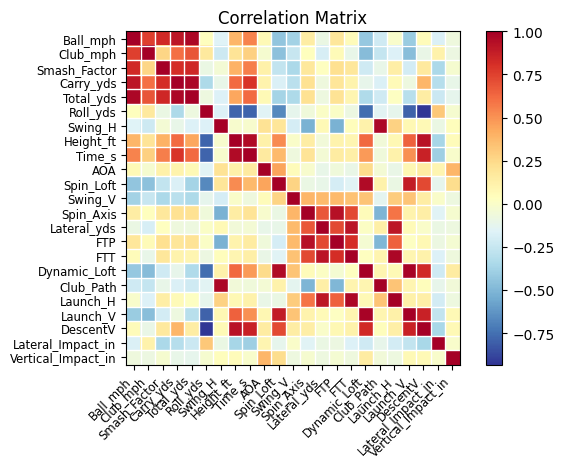

In [8]:
# Set larger figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Compute correlation matrix
corr_matrix = np.corrcoef(df[num_columns].dropna().T)

# Plot the correlation matrix
smg.plot_corr(corr_matrix, xnames=df[num_columns].columns)

# Show the plot
plt.show()


In [9]:
corr_matrix[3]

array([ 0.90529377,  0.60510404,  0.81711818,  1.        ,  0.96350986,
       -0.33845827, -0.1099707 ,  0.62064725,  0.79475601,  0.10353572,
       -0.17294748, -0.29220515,  0.21346582, -0.07048874,  0.1915481 ,
        0.10568397, -0.11237105, -0.17082231,  0.05590073, -0.07464664,
        0.38404762, -0.30903967, -0.10641975])

In [10]:


# Convert corr_matrix to DataFrame for easier manipulation
corr_df = pd.DataFrame(corr_matrix, index=num_columns, columns=num_columns)

# Extract correlation values for 'Carry_yds'
carry_yds_corr = corr_df.loc[:, 'Carry_yds'].drop('Carry_yds')  # Drop self-correlation

# Convert to a DataFrame for better display
carry_yds_corr_df = carry_yds_corr.reset_index()
carry_yds_corr_df.columns = ['Variable', 'Correlation with Carry_Yds']

# Display the table
carry_yds_corr_df


,Variable,Correlation with Carry_Yds
0,Ball_mph,0.905294
1,Club_mph,0.605104
2,Smash_Factor,0.817118
3,Total_yds,0.963510
4,Roll_yds,-0.338458
5,Swing_H,-0.109971
6,Height_ft,0.620647
7,Time_s,0.794756
8,AOA,0.103536
9,Spin_Loft,-0.172947


In [18]:
golfer_name = 'Dave'
club_name = '9 Iron'

df_choose = df[(df['Golfer'] == golfer_name) & (df['Club'] == club_name)]




mlfn.visualize_column_distribution(df_choose, num_columns)


Dave 7 Iron


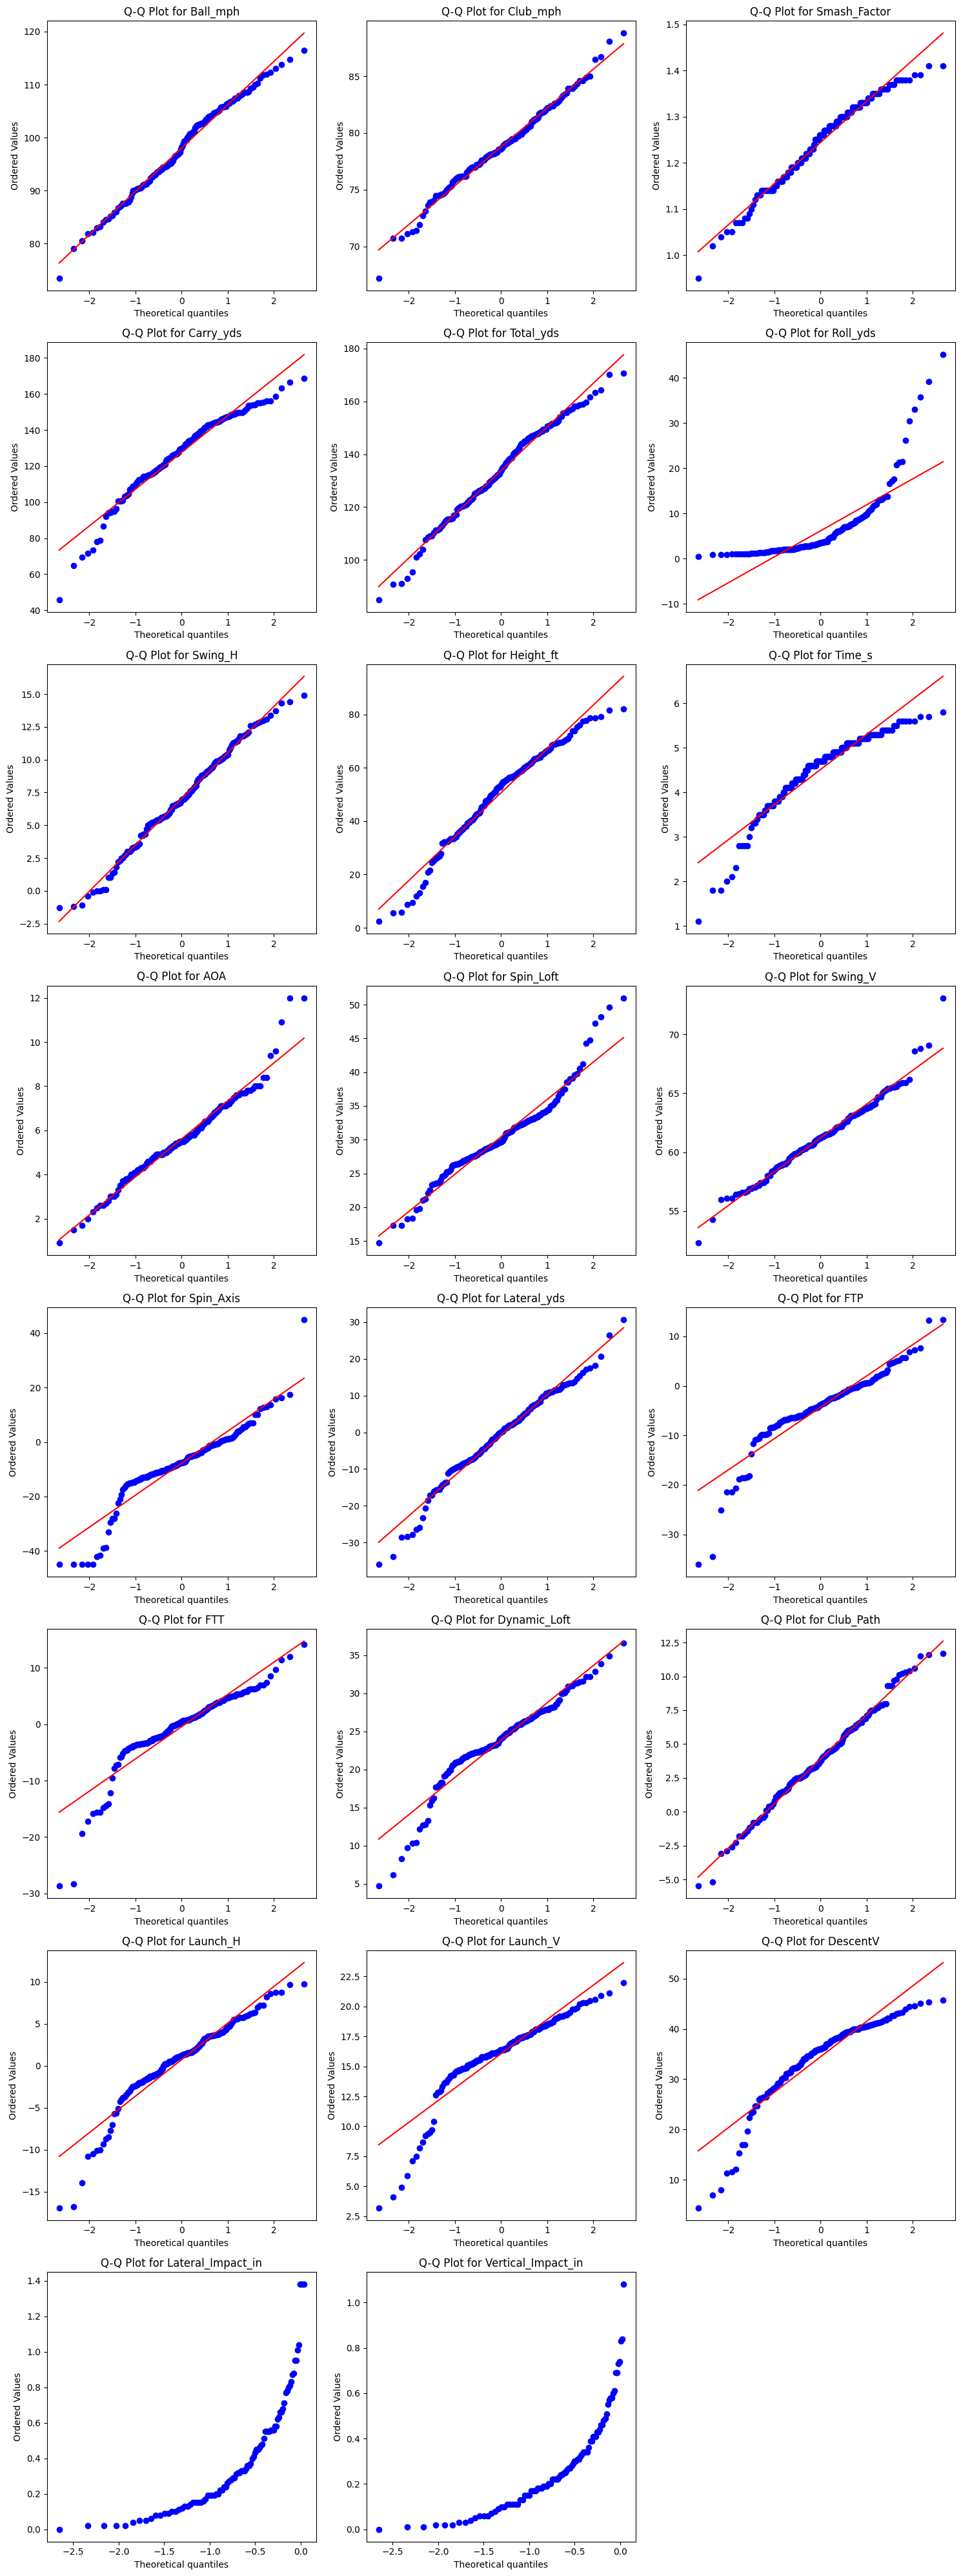

In [17]:
print(golfer_name, club_name)
mlfn.qq_plot(df_choose, num_columns)